In [18]:
import math
import threading

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

In [2]:
import gym
import tensorflow as tf

In [3]:
env = gym.make('CartPole-v0')

[2016-10-23 13:15:45,089] Making new env: CartPole-v0


In [4]:
def Networks(env, states, hidden_num):
    """Maps states tensor to the pair of policy and value tensors."""
    with tf.device("/cpu:0"):
        with tf.variable_scope('common'):
            hidden = tf.contrib.layers.relu(states, hidden_num,
                                            weights_initializer=tf.truncated_normal_initializer(stddev=1.),
                                            biases_initializer=tf.constant_initializer(0.1))
        with tf.variable_scope('policy'):
            logits = tf.contrib.layers.linear(hidden, env.action_space.n)
        with tf.variable_scope('value'):
            value_out = tf.contrib.layers.linear(hidden, 1)
        return logits, value_out

In [5]:
def PlotValue(sess, value, values):
    grid = np.meshgrid(*values)
    shape = np.shape(grid[0])
    vinput = np.reshape(grid, (len(values), -1)).transpose()
    output = sess.run(value, feed_dict={ac1._state: vinput})
    image = output.reshape(shape).squeeze()
    extent = []
    for v in values:
        if not isinstance(v, (float, int)):
            extent.append(np.min(v, ))
            extent.append(np.max(v))
            
    plt.colorbar(plt.imshow(image, interpolation="nearest", extent=extent, aspect='auto'))

-------

In [6]:
def discounted_rewards(rewards, gamma, bootstrap):
    rank = rewards.get_shape().ndims or tf.rank(reward)
    
    reverse_params = tf.concat(0, [
            tf.constant([True]),
            tf.fill(tf.expand_dims(rank - 1, 0), False)
        ])
    reverse_rew = tf.reverse(rewards, reverse_params)
    
    summed = tf.scan(lambda a, x: x + gamma * a, reverse_rew, initializer=bootstrap,
                     parallel_iterations=1, back_prop=False)
    return tf.reverse(summed, reverse_params)

In [7]:
def Last(bb):
    size = tf.shape(bb)[0]
    return tf.reshape(tf.gather(bb, size - 1), [])

In [17]:
DEFAULT_OPTIONS = {
    'clip_grad': 5.,
    'gamma': 0.99,
    'learning_rate': 0.01,
    'eps_decay': 3000,
    'rollout': 20,
    'threads': 1,
}

In [99]:
class ActorCritic(object):
    def __init__(self, env, build_networks, options=DEFAULT_OPTIONS):
        self._env = env
        self._env_example = env()
        self._options = options
        state_dim = self._env_example.observation_space.shape[0]
        self._graph = tf.Graph()
        self._threads = []
        with self._graph.as_default(), tf.device('/cpu:0'):
            self._state = tf.placeholder(tf.float32, shape=[None, state_dim], name='states')
            self._action = tf.placeholder(tf.int64, shape=[None], name='actions')
            self._reward = tf.placeholder(tf.float32, shape=[None, 1], name='rewards')
            self._done = tf.placeholder(tf.float32, shape=[1], name='done')      

            self._policy_logits, self._baseline = build_networks(self._env_example, self._state)

            self._discount = discounted_rewards(self._reward, options['gamma'],
                                                Last(self._baseline) * (1. - self._done))
            
            self._tf_policy = tf.reshape(tf.multinomial(self._policy_logits, 1), [])

        
            with tf.device('/cpu:0'):
                optimizer = tf.train.AdamOptimizer(options['learning_rate'])

            advantage = tf.reshape(self._discount, [-1, 1]) - self._baseline

            cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(self._policy_logits,
                                                                           tf.reshape(self._action, [-1]))
            policy_loss = tf.reduce_mean(tf.mul(cross_entropy, tf.stop_gradient(advantage)))
            policy_entropy = tf.reduce_mean(-tf.nn.softmax(self._policy_logits) * 
                                            tf.nn.log_softmax(self._policy_logits))
            value_loss = 0.5 * tf.reduce_mean(tf.square(advantage))

            loss = policy_loss + 0.25 * value_loss - 0.01 * policy_entropy

            grads = optimizer.compute_gradients(loss, tf.get_collection(tf.GraphKeys.VARIABLES))
            if 'clip_grad' in options:
                grads = [(tf.clip_by_norm(g, options['clip_grad']), v)
                         for g, v in grads]

            for grad, var in grads:
                tf.histogram_summary(var.name, var)
                if grad is not None:
                    tf.histogram_summary('{}/grad'.format(var.name), grad)            

            self._global_step = tf.Variable(0, name='global_step', trainable=False)
            self._epsilon = 1.0 / (1.0 + tf.cast(self._global_step, tf.float32) 
                                   / options.get('eps_decay', 3000.))
            self._train_op = optimizer.apply_gradients(grads, self._global_step)
            
            tf.histogram_summary("Predicted baseline", self._baseline)
            tf.scalar_summary("Loss/Actor", policy_loss)
            tf.scalar_summary("Loss/Critic", value_loss)
            tf.scalar_summary("Loss/Entropy", policy_entropy)
            tf.scalar_summary("Loss/Total", loss)
            tf.scalar_summary("Epsilon", self._epsilon)
            tf.scalar_summary("Done", tf.reduce_mean(self._done))

            self._summary_op = tf.merge_all_summaries()

            self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

    def Init(self, run_id):
        with self._graph.as_default():
            self.sess.run(tf.initialize_all_variables())
            self._writer = tf.train.SummaryWriter(
                '/media/vertix/UHDD/tmp/tensorflow_logs/{}/{:02d}'.format(self._env_example.spec.id, run_id))
            self._coord = tf.train.Coordinator()

    def Close(self):
        self._coord.request_stop()
        self._coord.join(self._threads)
        self.sess.close()
            
    def CleanPolicy(self, observation):
        return self.sess.run(self._tf_policy,
                             {self._state:
                              observation.reshape(1, self._env_example.observation_space.shape[0])})
    
    def EpsilonGreedyPolicy(self, observation):
        epsilon = self.sess.run(self._epsilon)
        if np.random.rand() < epsilon:
            return self._env_example.action_space.sample()
        else:
            return self.CleanPolicy(observation)

    def Learn(self, num_steps):
        if any([t.is_alive() for t in self._threads]):
            print 'At least one thread is already running!'
            return

        self._threads = [threading.Thread(target=self.LearnThread, args=(num_steps,))
                         for _ in xrange(self._options['threads'])]
        for t in self._threads:
            t.start()
        
    def LearnThread(self, num_steps):
        env = self._env()
        obs = env.reset()

        observations, actions, rewards = [], [], []
        done = False
        episode_reward, episode_len = 0., 0.

        while not self._coord.should_stop():
            observations.append(obs)
            act = self.EpsilonGreedyPolicy(obs)
            actions.append(act)
            
            obs, reward, done, _ = env.step(act)
            episode_reward += reward
            episode_len += 1.
            rewards.append(reward)
            
            if done or len(observations) >= self._options.get('rollout', 20):
                # TODO(vertix): Use queues to run learn in parallel and not block env.
                step = self.Update(observations, actions, rewards, done)
                if done:
                    obs = env.reset()
                    done = False
                    self._writer.add_summary(tf.Summary(value=[
                                tf.Summary.Value(tag='Env/Rewards', simple_value=episode_reward),
                                tf.Summary.Value(tag='Env/Length', simple_value=episode_len),                                
                            ]), step)
                    episode_reward, episode_len = 0., 0.

                observations, actions, rewards = [], [], []
            
                if step >= num_steps:
                    print 'Many steps!'
                    self._coord.request_stop()

    def Update(self, observations, actions, rewards, done):
        feed_dict = {self._state: observations,
                     self._action: actions,
                     self._reward: np.reshape(rewards, (-1, 1)),
                     self._done: [1.0 if done else 0.0]}
            
        step, _ = self.sess.run([self._global_step,self._train_op], feed_dict)

        if step % 50 == 0:
            self._writer.add_summary(self.sess.run(self._summary_op, feed_dict), step)
        return step

In [101]:
ac1.Close()
ac1 = ActorCritic(lambda: env, lambda env, st: Networks(env, st, 10))

In [102]:
ac1.Init(1)

In [103]:
ac1.Learn(150000)

[2016-10-24 00:00:17,770] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[2016-10-24 00:00:17,790] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
Exception in thread Thread-41:
Traceback (most recent call last):
  File "/home/vertix/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/vertix/anaconda2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-94-e4c276b8aa3b>", line 111, in LearnThread
    obs, reward, done, _ = env.step(act)
  File "/home/vertix/anaconda2/lib/python2.7/site-packages/gym/core.py", line 122, in step
    observation, reward, done, info = self._step(action)


In [83]:
ac1.sess.run(ac1._global_step)

5342

In [104]:
options = dict(DEFAULT_OPTIONS)
options['threads'] = 1

In [105]:
ac2.Close()
ac2 = ActorCritic(lambda: env, lambda env, st: Networks(env, st, 10), options)

In [106]:
ac2.Init(2)

In [107]:
ac2.Learn(150000)

[2016-10-24 00:00:34,812] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
Exception in thread Thread-46:
Traceback (most recent call last):
  File "/home/vertix/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/vertix/anaconda2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-99-e4c276b8aa3b>", line 111, in LearnThread
    obs, reward, done, _ = env.step(act)
  File "/home/vertix/anaconda2/lib/python2.7/site-packages/gym/core.py", line 122, in step
    observation, reward, done, info = self._step(action)
  File "/home/vertix/anaconda2/lib/python2.7/site-packages/gym/envs/classic_control/cartpole.py", line 91, in _step
    self.steps_beyond_done += 1
TypeError: unsupported operand type(s) for +=: 'NoneType' and 'int'



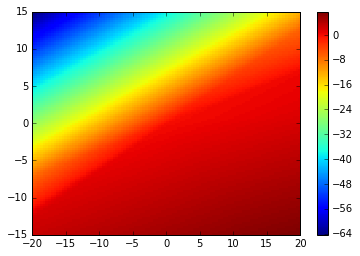

In [39]:
a = PlotValue(sess, value, [0, 0, np.linspace(-20., 20., 100), np.linspace(-15., 15., 100), 0., 0.])

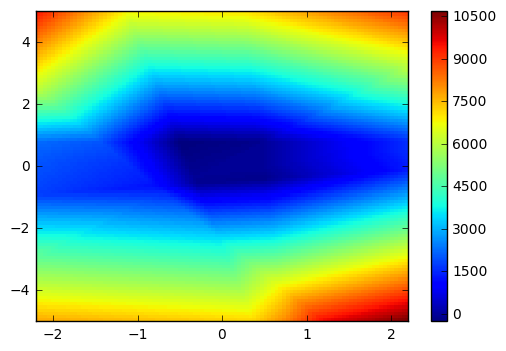

In [43]:
a = PlotValue(ac1.sess, ac1._baseline,
              [np.linspace(-2.2, 2.2, 100), np.linspace(-5., 5., 100), 0, 0])

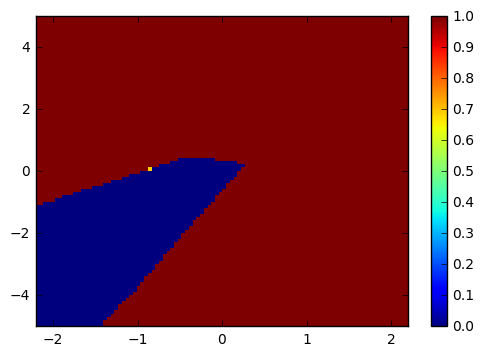

In [44]:
a = PlotValue(ac1.sess, tf.nn.softmax(ac1._policy_logits)[:, 0],
              [0, 0, np.linspace(-2.2, 2.2, 100), np.linspace(-5., 5., 100)])

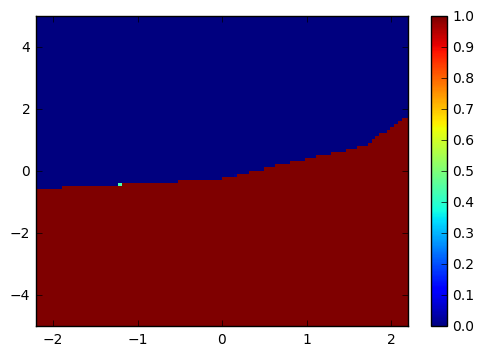

In [45]:
a = PlotValue(ac1.sess, tf.nn.softmax(ac1._policy_logits)[:, 0],
              [np.linspace(-2.2, 2.2, 100), np.linspace(-5., 5., 100), 0, 0])

In [286]:
env.step(1)

(array([ 0.99847408,  0.05522233, -0.41032117, -0.91194108, -1.1073869 ,
         3.68590749]), -1.0, False, {})

In [ ]:
def PlayEpisode(env, policy, render=False, max_steps=None):
    observations, actions, rewards = [], [], []
    observation = None
    done = False
    steps = 0
    observation = env.reset()
    
    while not done and (max_steps is None or steps < max_steps):
        if render:
            env.render()
        
        observations.append(observation)
        action = policy(observation)
        actions.append(action)

        observation, reward, done, info = env.step(action)
        rewards.append(reward)  
        steps += 1

    if render:
        env.render(close=True)

    if isinstance(env.action_space, gym.spaces.Discrete):
        actions = np.reshape(actions, (len(actions), 1))
        
    return observations, actions, rewards, done

In [21]:
env.render(close=True)

In [47]:
# %%prun

try:
    done = False
    obs = env.reset()
    r = 0
    while not done:
        env.render()
        a = ac1.CleanPolicy(obs)
        obs, reward, done, _ = env.step(a)
        r += reward
    print r
finally:
    env.render(close=True)

37.0


In [61]:
PlayEpisode(env, ac1.CleanPolicy(), True)

NameError: name 'PlayEpisode' is not defined

In [22]:
env.reset()
print len(PlayEpisode(env, TFPolicy(sess, policy), True)[0])

62


In [19]:
# %%prun
for _ in range(10):
    print LearnEpisode(env, sess, policy, value)

400.0
70.0
109.0
400.0
260.0
70.0
218.0
80.0
180.0
49.0


In [ ]:
for _ in range(100000):
    LearnEpisode(env, sess, policy, value)
print LearnEpisode(env, sess, policy, value)
print LearnEpisode(env, sess, policy, value)
print LearnEpisode(env, sess, policy, value)
# print np.mean([LearnEpisode(env, sess, policy, value) for _ in range(100)])

In [47]:
env.reset()
PlayEpisode(env, TFPolicy(sess, policy), True)

OSError: [Errno 12] Cannot allocate memory